In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class EEGfMRIDataset(Dataset):
    def __init__(self, eeg_data, fmri_data):
        self.eeg_data = eeg_data
        self.fmri_data = fmri_data

    def __len__(self):
        return len(self.eeg_data)

    def __getitem__(self, idx):
        eeg = self.eeg_data[idx]
        fmri = self.fmri_data[idx]
        return eeg, fmri

# Load your dataset
data_path = '/home/aca10131kr/datasets/01_eeg_fmri_data.h5'
with h5py.File(data_path, 'r') as f:
    eeg_train = np.array(f['eeg_train'][:80])
    fmri_train = np.array(f['fmri_train'][:80])
    eeg_test = np.array(f['eeg_test'][:20])
    fmri_test = np.array(f['fmri_test'][:20])

# Normalize the data
eeg_train = (eeg_train - np.min(eeg_train)) / (np.max(eeg_train) - np.min(eeg_train))
fmri_train = (fmri_train - np.min(fmri_train)) / (np.max(fmri_train) - np.min(fmri_train))
eeg_test = (eeg_test - np.min(eeg_test)) / (np.max(eeg_test) - np.min(eeg_test))
fmri_test = (fmri_test - np.min(fmri_test)) / (np.max(fmri_test) - np.min(fmri_test))

batch_size = 16

# Create the dataset and dataloader
train_dataset = EEGfMRIDataset(torch.tensor(eeg_train, dtype=torch.float32), torch.tensor(fmri_train, dtype=torch.float32))
test_dataset = EEGfMRIDataset(torch.tensor(eeg_test, dtype=torch.float32), torch.tensor(fmri_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose3d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose3d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose3d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv3d(8, 64, kernel_size=1),
            nn.Upsample(size=(64, 64, 30), mode='trilinear', align_corners=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

In [4]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv3d(64, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv3d(32, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv3d(16, 8, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv3d(8, 1, kernel_size=3, stride=2, padding=1)
        self.sigmoid = nn.Sigmoid()
        self.fc = None  # Fully connected layer will be initialized during forward pass

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)
        # print(f'After flattening: {x.shape}')

        # Initialize the fully connected layer dynamically
        if self.fc is None or self.fc.in_features != x.size(1):
            self.fc = nn.Linear(x.size(1), 1).to(x.device)
        
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
netD = Discriminator().to(device)
dummy_input = torch.randn(16, 64, 269, 10, 1).to(device)
output = netD(dummy_input)
print(output.shape)


torch.Size([16, 1])


In [5]:
# Create the dataset and dataloader
train_dataset = EEGfMRIDataset(torch.tensor(eeg_train, dtype=torch.float32), torch.tensor(fmri_train, dtype=torch.float32))
test_dataset = EEGfMRIDataset(torch.tensor(eeg_test, dtype=torch.float32), torch.tensor(fmri_test, dtype=torch.float32))

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

netG = Generator().to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

num_epochs = 20
real_label = 1
fake_label = 0

for epoch in range(num_epochs):
    for i, data in enumerate(train_loader):
        netD.zero_grad()
        
        # Train with real fMRI data
        eeg, real_fmri = data
        eeg, real_fmri = eeg.to(device), real_fmri.to(device)
        batch_size = real_fmri.size(0)
        labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_fmri).view(-1)
        lossD_real = criterion(output, labels)
        lossD_real.backward()
        
        # Train with fake fMRI data
        noise = eeg
        fake_fmri = netG(noise)
        labels.fill_(fake_label)
        output = netD(fake_fmri.detach()).view(-1)
        lossD_fake = criterion(output, labels)
        lossD_fake.backward()
        optimizerD.step()
        
        # Update generator
        netG.zero_grad()
        labels.fill_(real_label)
        output = netD(fake_fmri).view(-1)
        lossG = criterion(output, labels)
        lossG.backward()
        optimizerG.step()
        
        if len(train_loader) >= 10 and (i+1) % (len(train_loader) // 10) == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], '
                  f'Loss D: {lossD_real.item() + lossD_fake.item():.4f}, Loss G: {lossG.item():.4f}')
        
print('Finished Training')

Finished Training


In [6]:
!nvidia-smi

Thu Jun 20 18:01:28 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:B2:00.0 Off |                    0 |
| N/A   53C    P0    84W / 300W |  13450MiB / 16384MiB |     85%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [18]:
# torch.cuda.empty_cache()

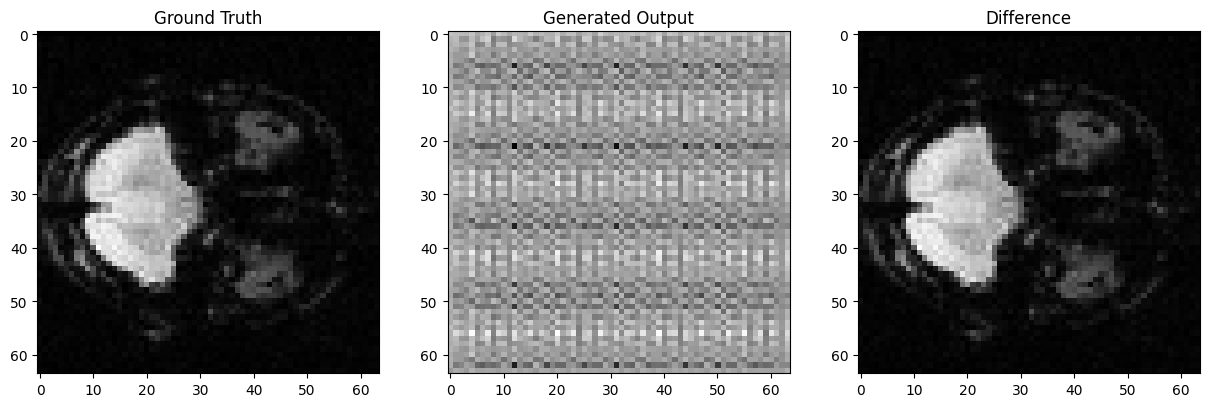

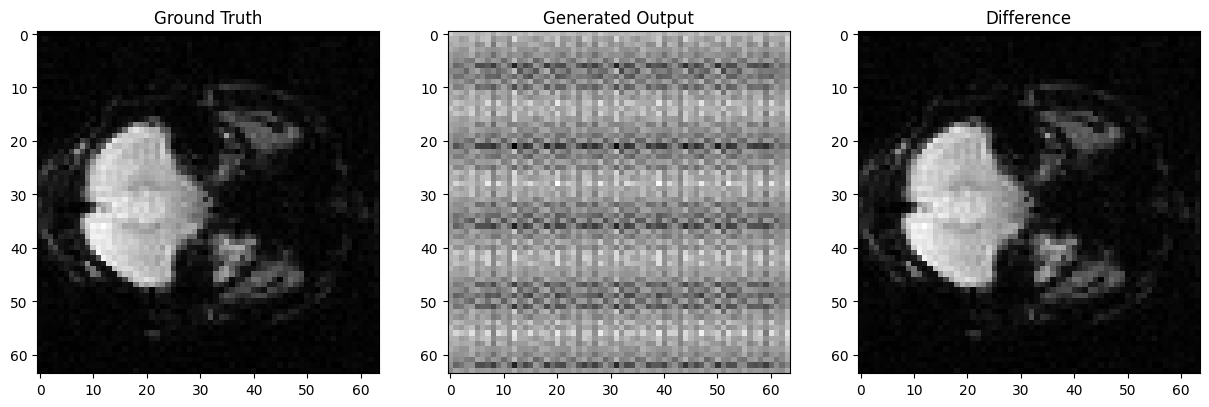

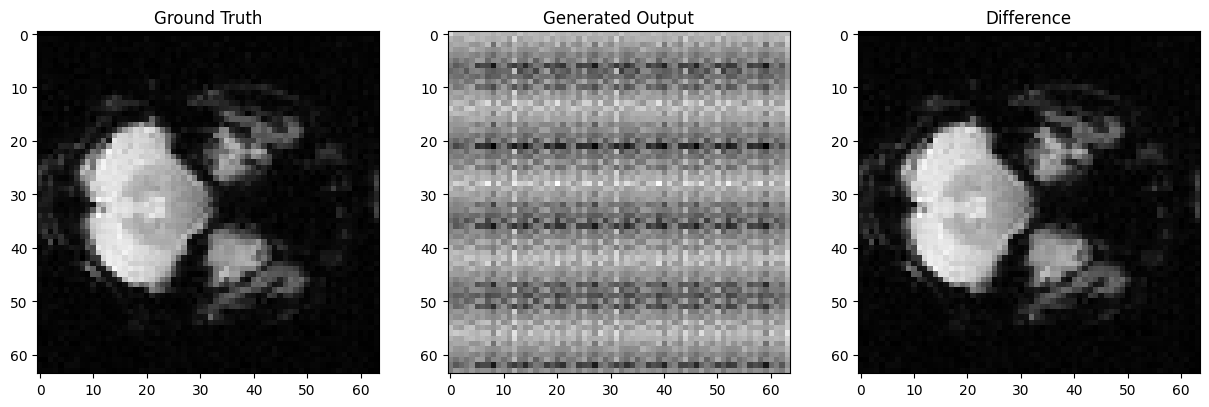

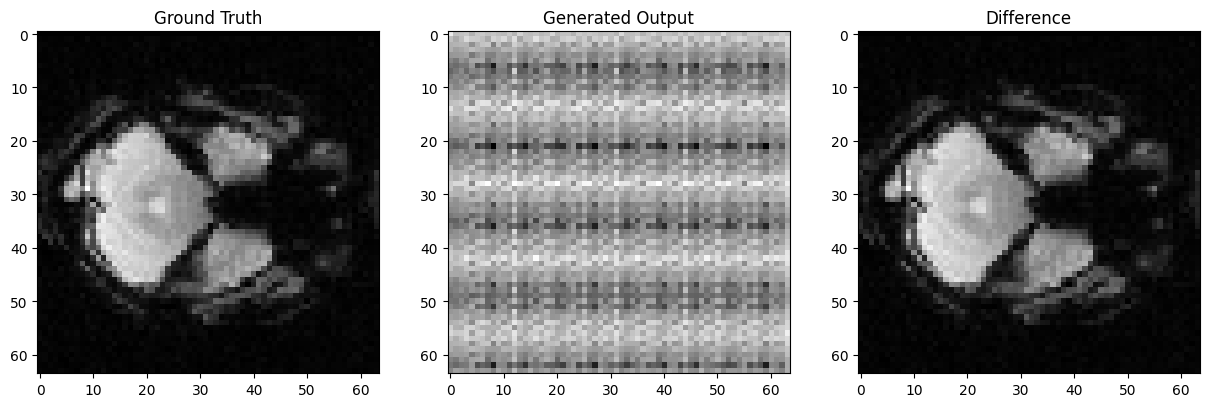

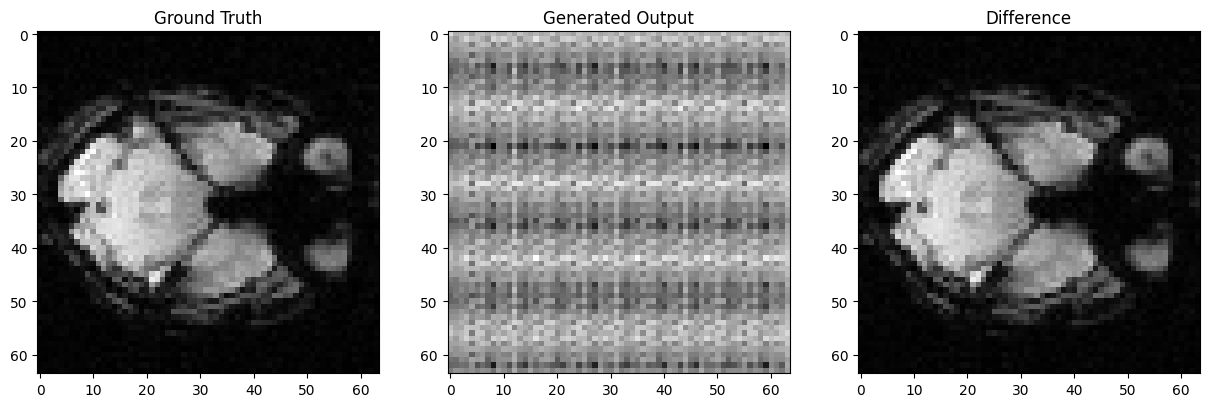

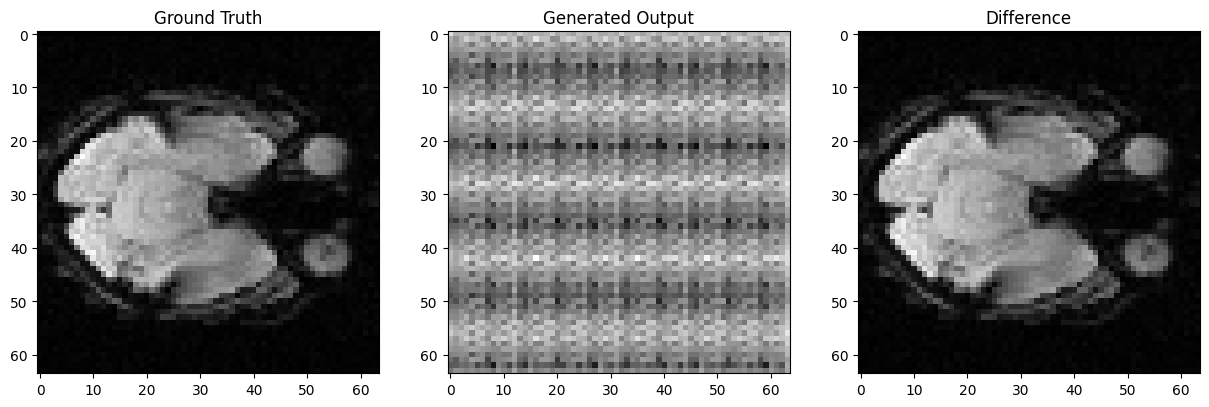

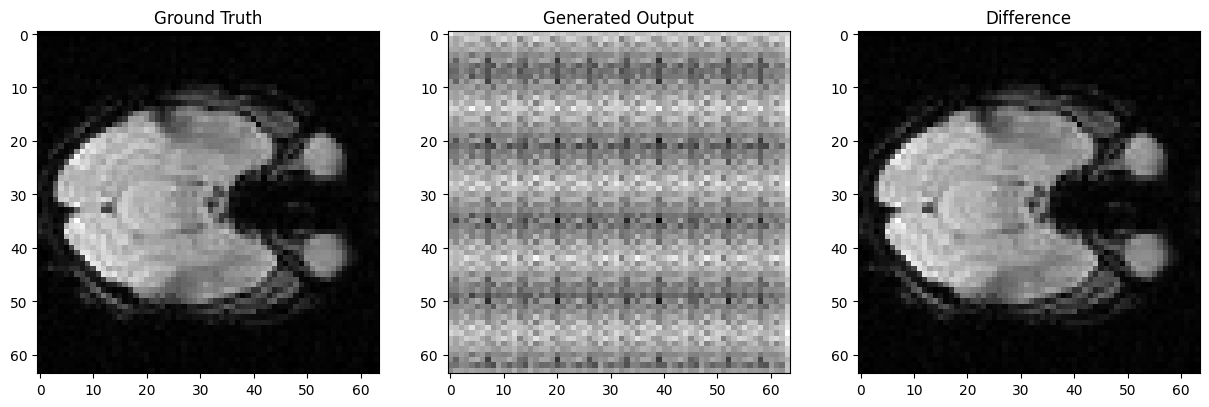

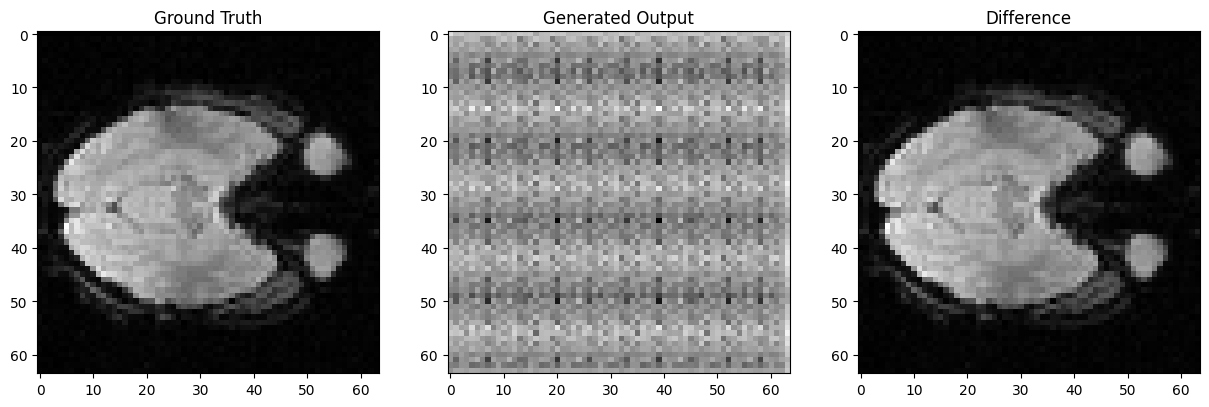

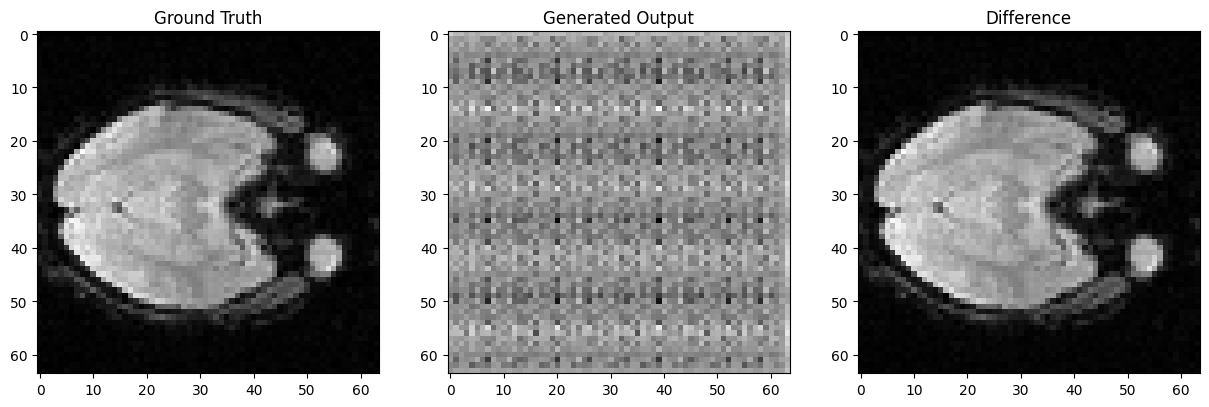

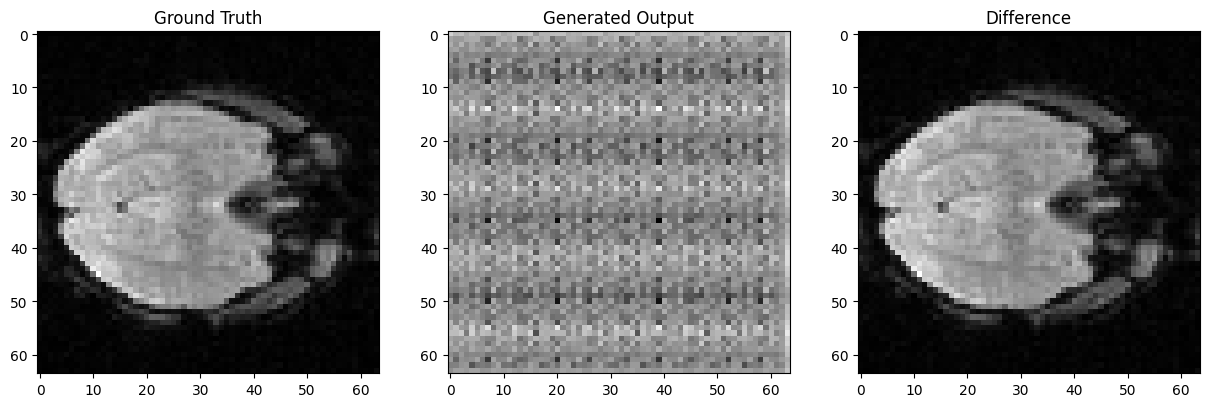

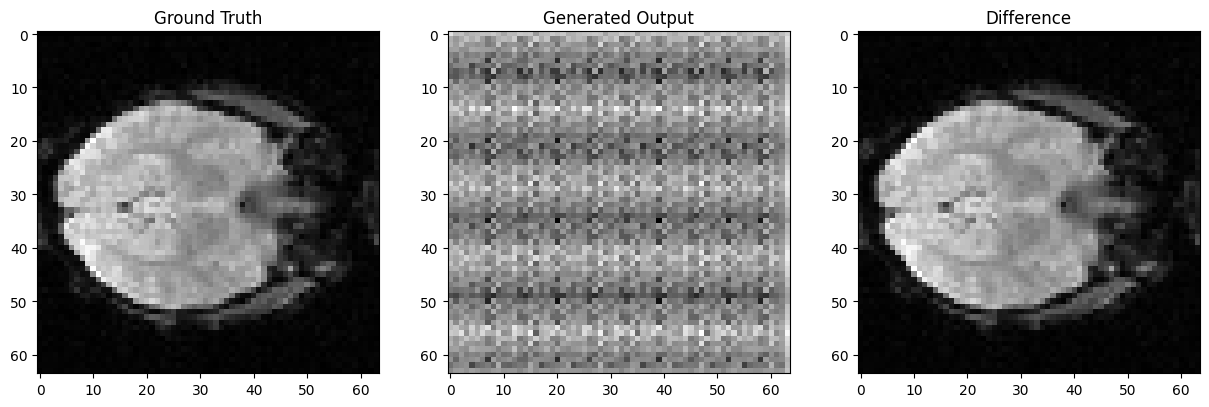

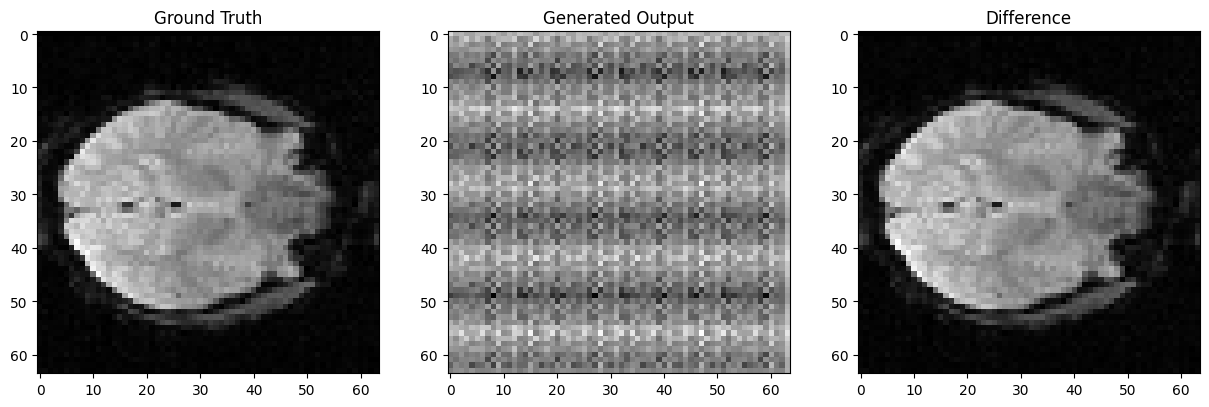

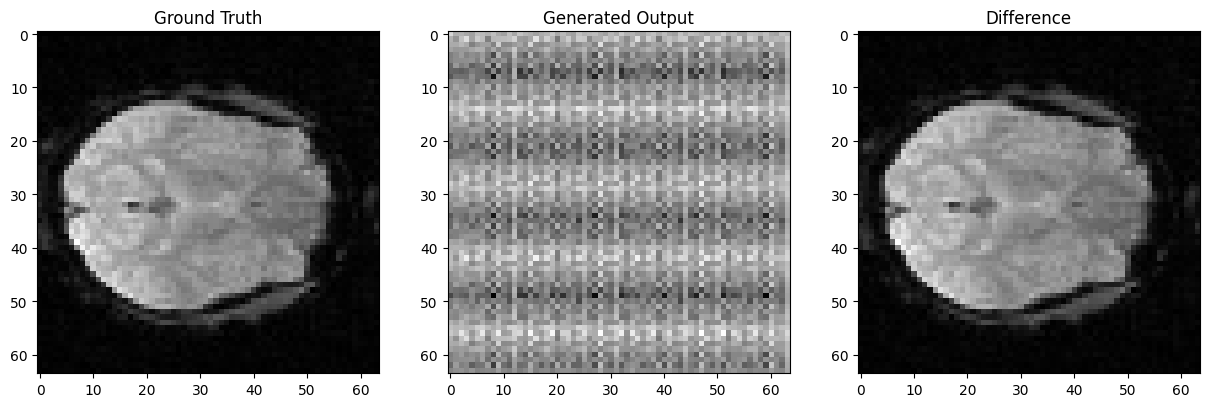

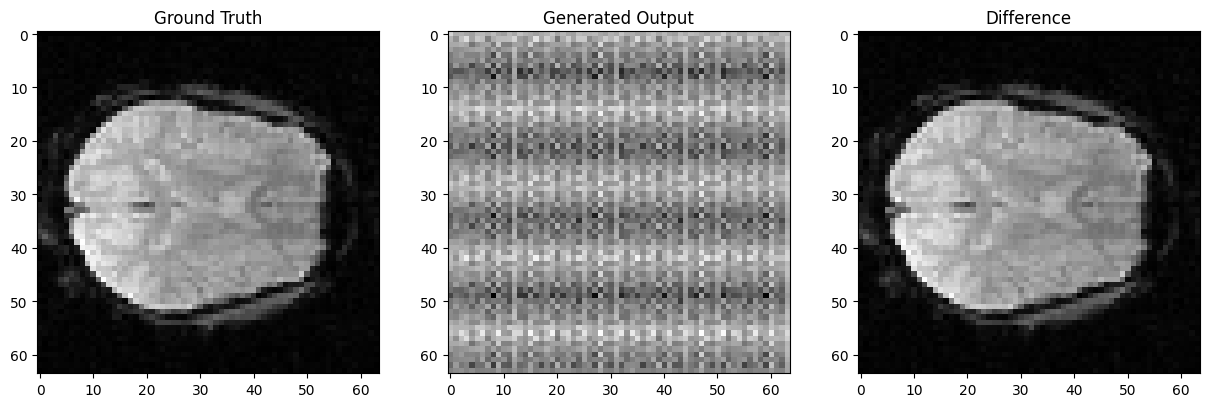

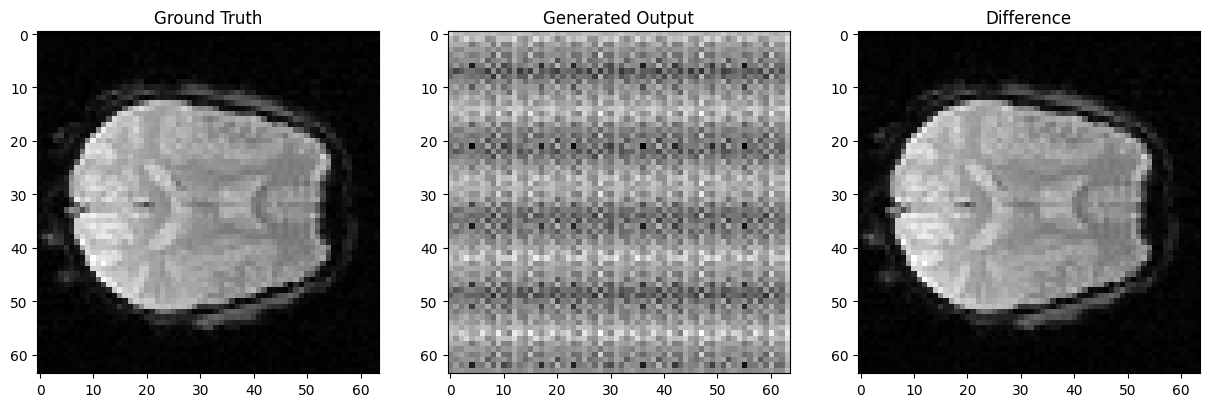

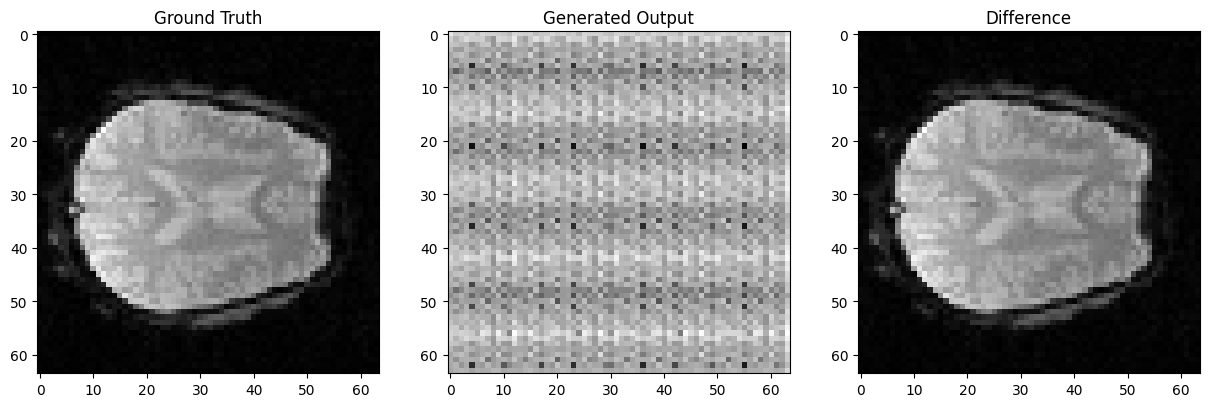

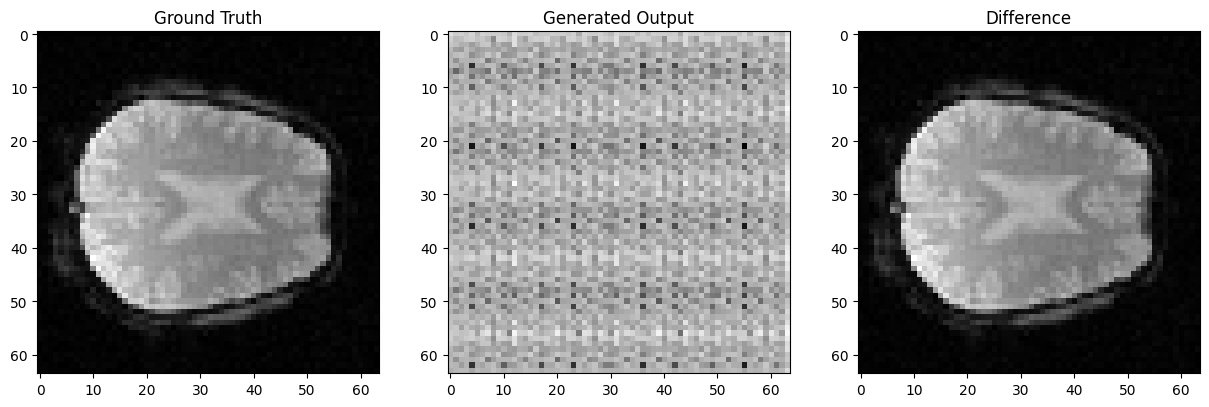

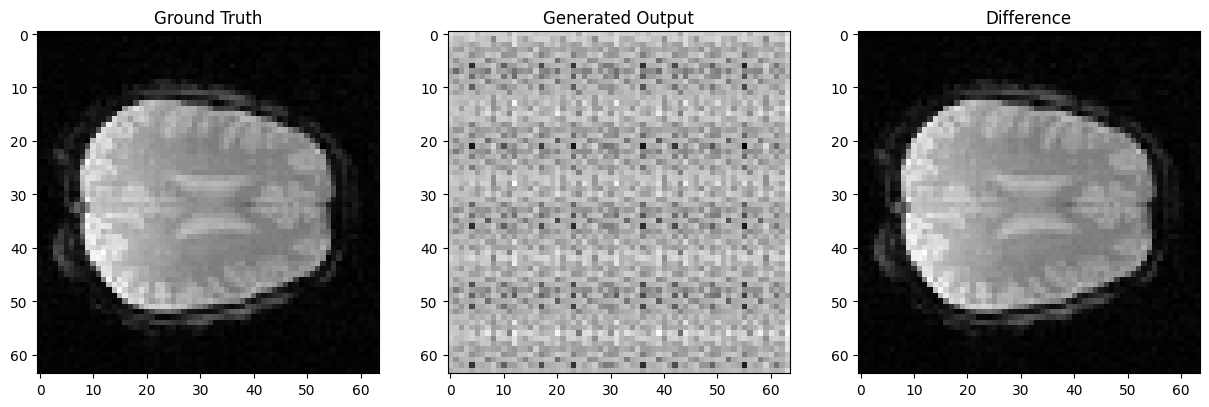

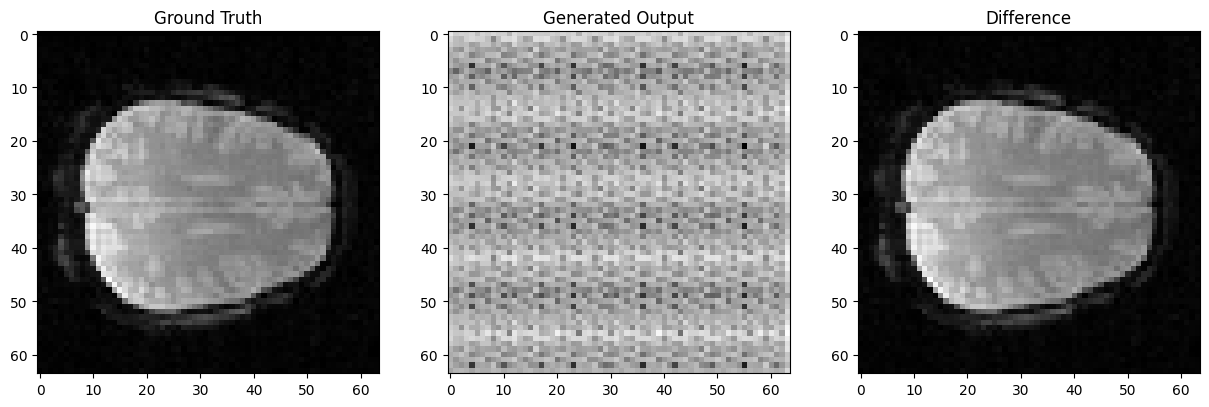

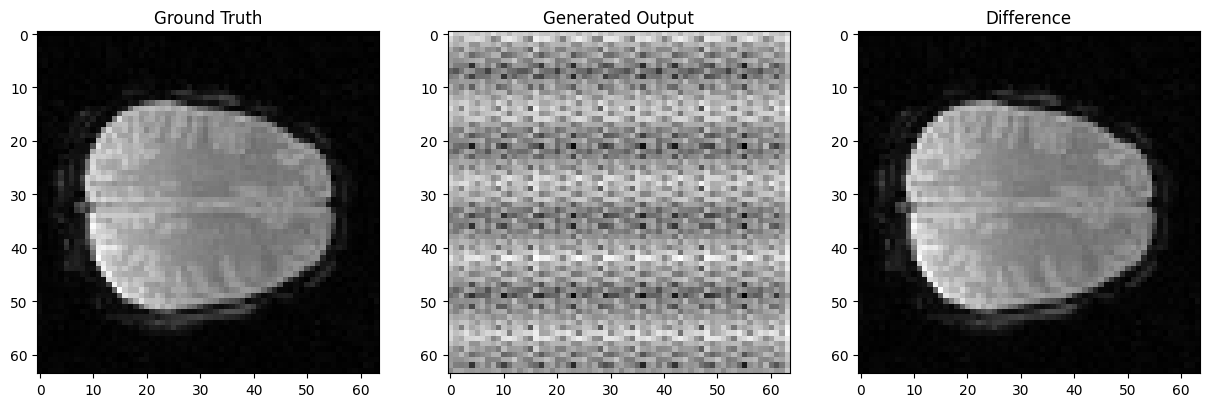

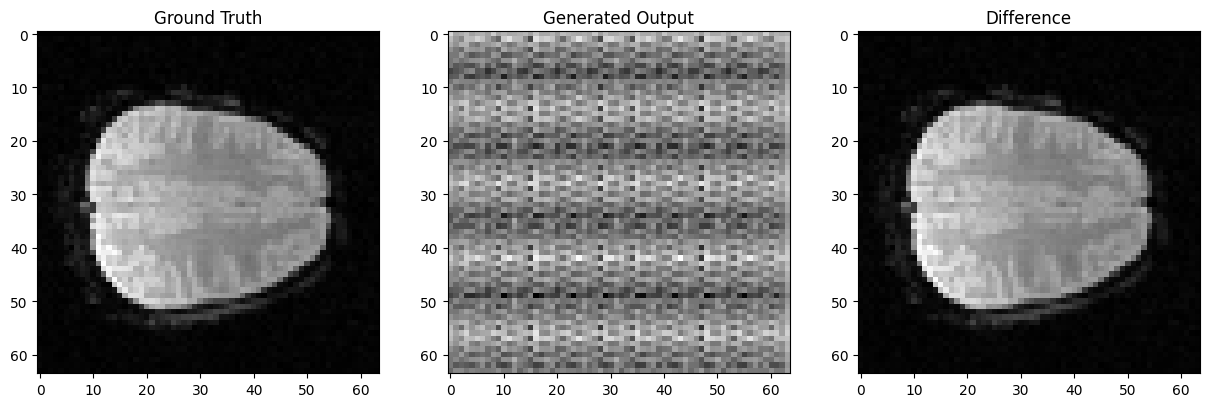

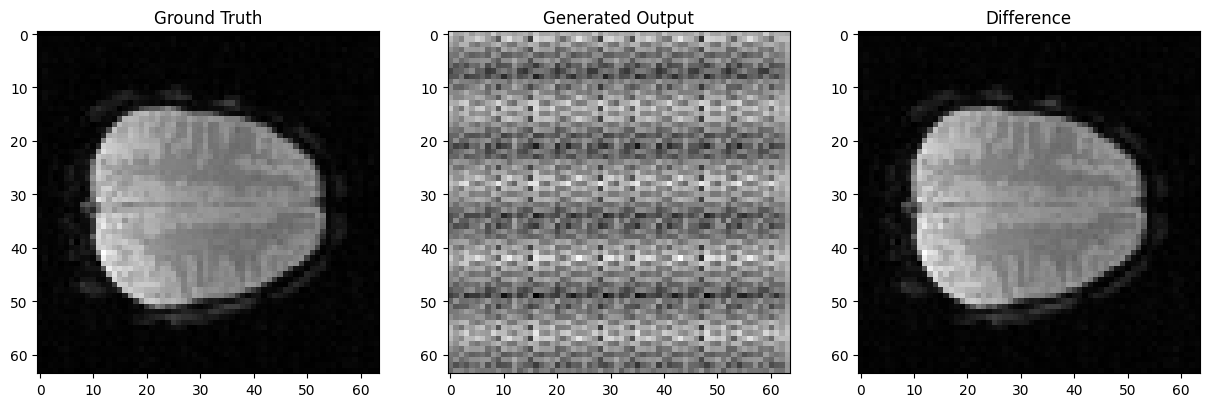

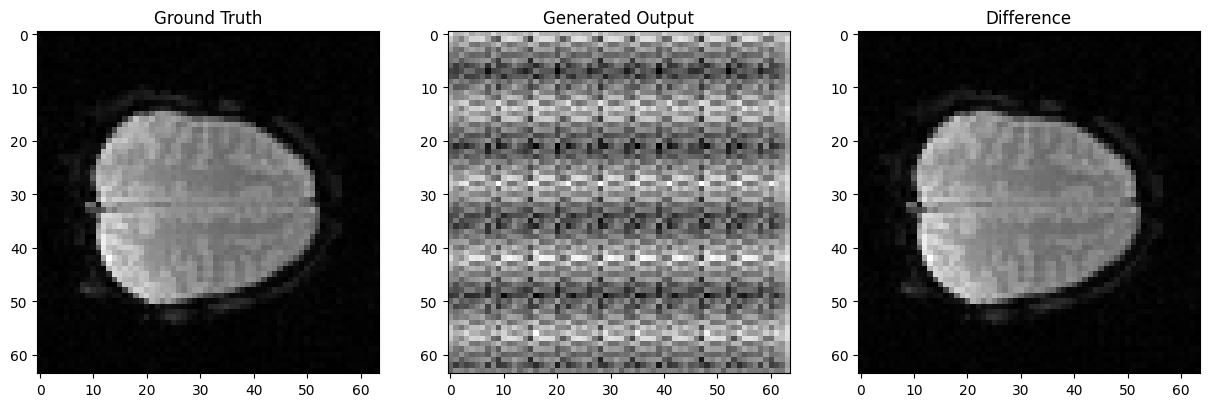

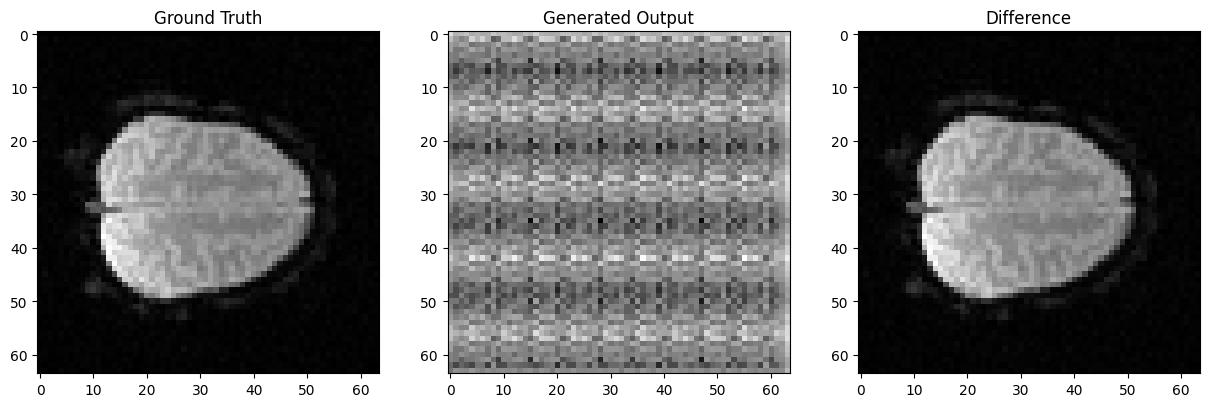

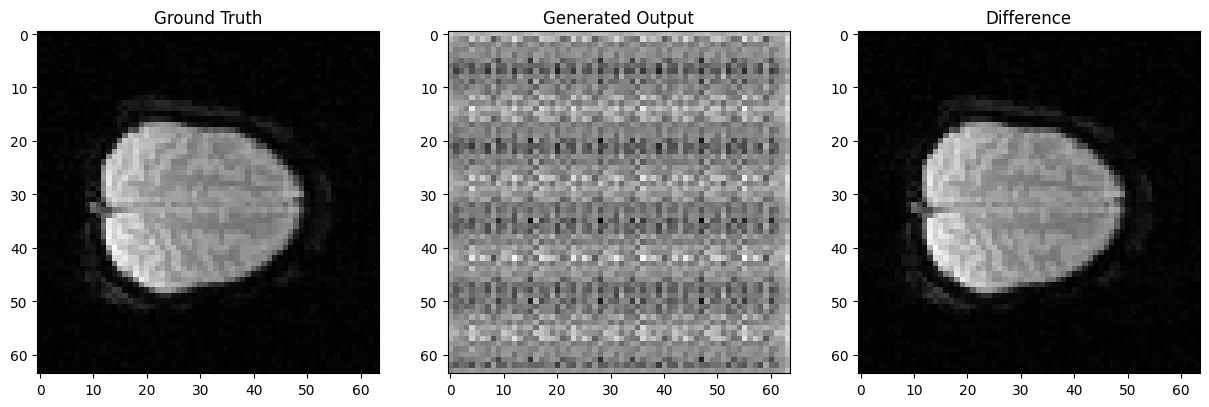

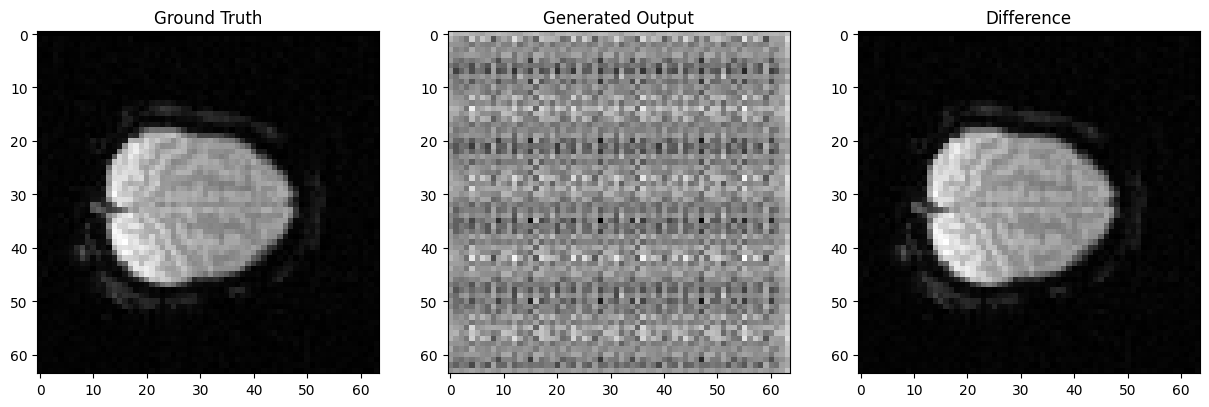

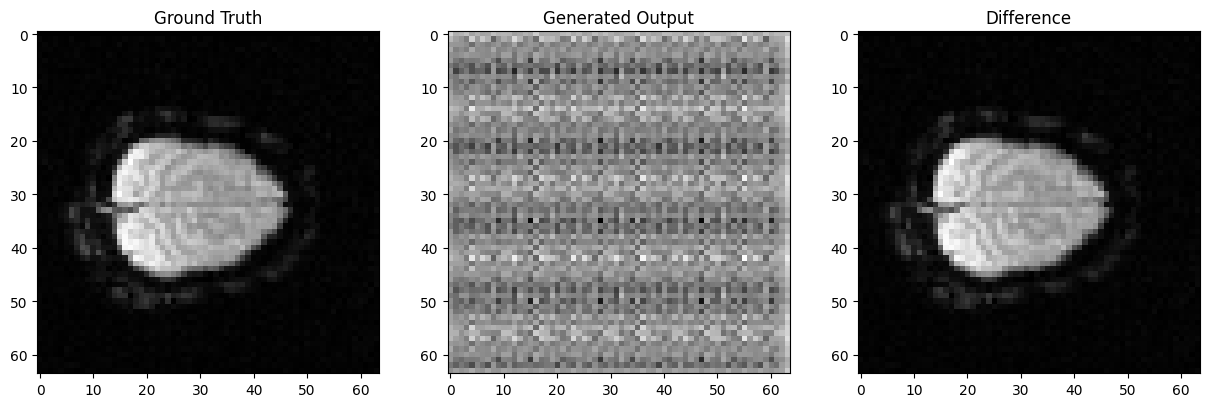

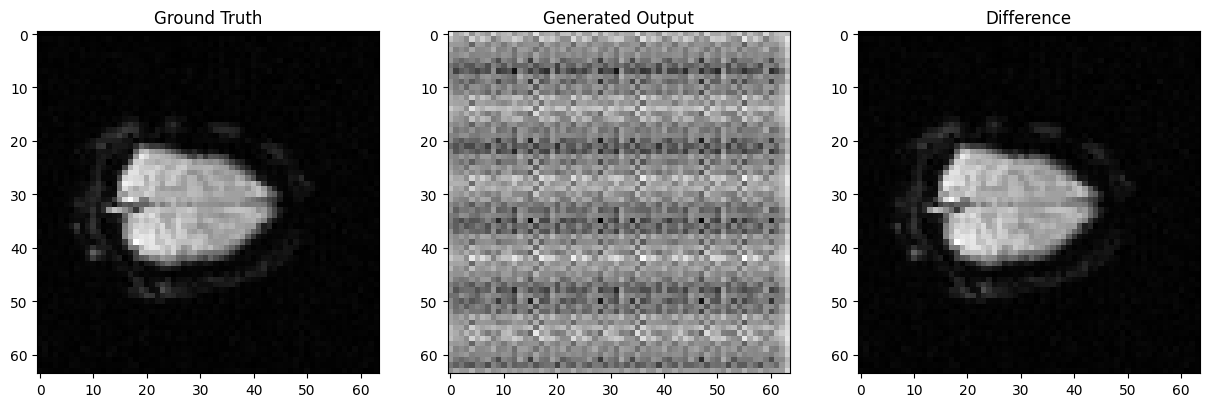

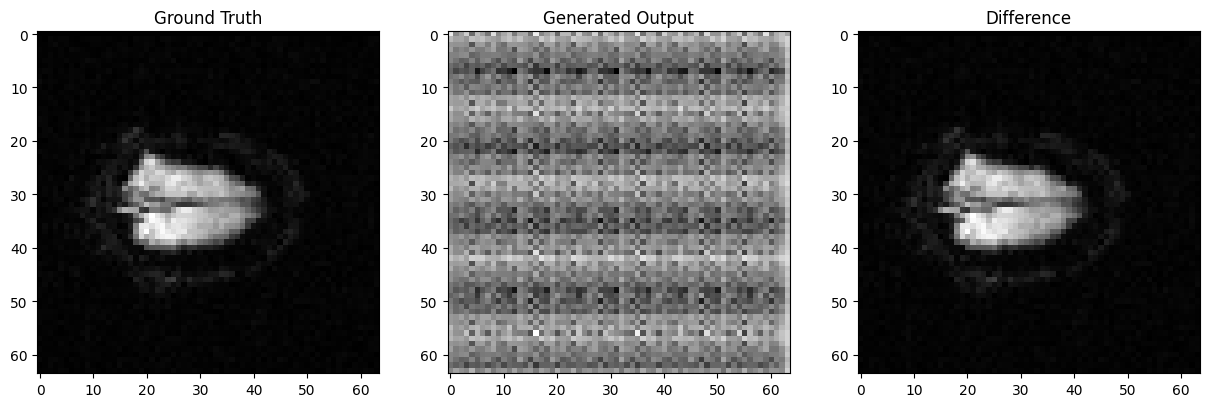

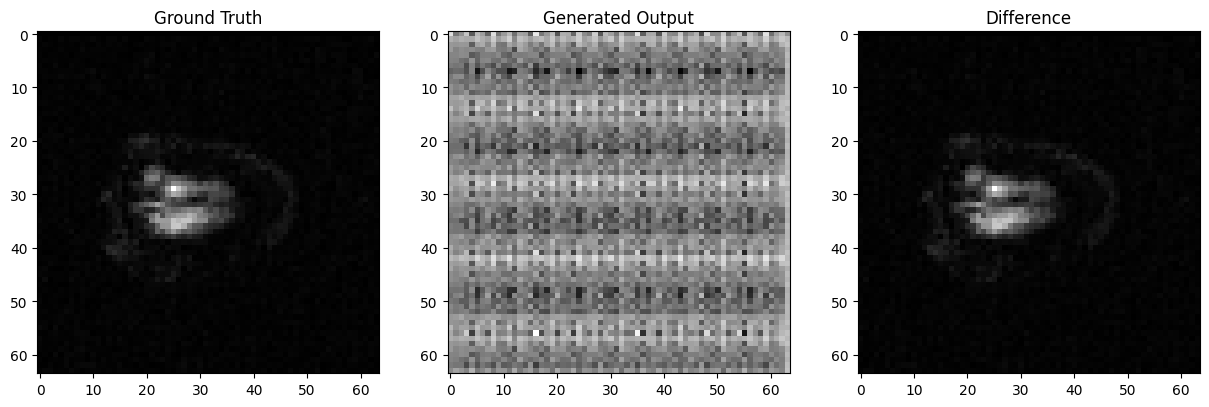

In [7]:
# Put the model in evaluation mode
netG.eval()

# Get a batch of test inputs
test_batch = next(iter(test_loader))
inputs, labels = test_batch
inputs, labels = inputs.to(device), labels.to(device)

# Generate outputs using the generator
with torch.no_grad():
    outputs = netG(inputs)

# Convert to NumPy arrays
inputs_np = inputs.cpu().numpy()
labels_np = labels.cpu().numpy()
outputs_np = outputs.cpu().numpy()

# Permute labels to match the shape of outputs
labels_np = np.transpose(labels_np, (0, 4, 1, 2, 3))

# Function to plot the data
def plot_comparison(labels, outputs, slice_idx, depth_idx):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Select a specific depth slice
    labels_slice = labels[slice_idx, 0, :, :, depth_idx]
    outputs_slice = outputs[slice_idx, 0, :, :, depth_idx]
    diff_slice = labels_slice - outputs_slice

    # Ensure the selected slices are 2D
    labels_slice = labels_slice if labels_slice.ndim == 2 else labels_slice[:, :, 0]
    outputs_slice = outputs_slice if outputs_slice.ndim == 2 else outputs_slice[:, :, 0]
    diff_slice = diff_slice if diff_slice.ndim == 2 else diff_slice[:, :, 0]

    axes[0].imshow(labels_slice, cmap='gray')
    axes[0].set_title('Ground Truth')

    axes[1].imshow(outputs_slice, cmap='gray')
    axes[1].set_title('Generated Output')

    axes[2].imshow(diff_slice, cmap='gray')
    axes[2].set_title('Difference')

    plt.show()

# Plot a comparison for a specific slice and depth
for depth_idx in range(30):  # Iterate through all depth indices
    plot_comparison(labels_np, outputs_np, slice_idx=0, depth_idx=depth_idx)